In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize


stopwords = set(stopwords.words('english'))

In [2]:
train_df = pd.read_csv('../data/raw/jigsaw/train.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_df.shape

(159571, 8)

In [4]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
train_df.iloc[:, 2:].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [6]:
train_df['occurrence'] = train_df.iloc[:, 2:].sum(axis=1)
train_df[train_df['occurrence'] > 1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,4


In [7]:
train_df['clean'] = train_df['occurrence'].map(lambda x: 1 if x == 0 else 0)
train_df['multilabel'] = train_df['occurrence'].map(lambda x: 1 if x > 1 else 0)

train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,1,0


/Users/affan/.conda/envs/detox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


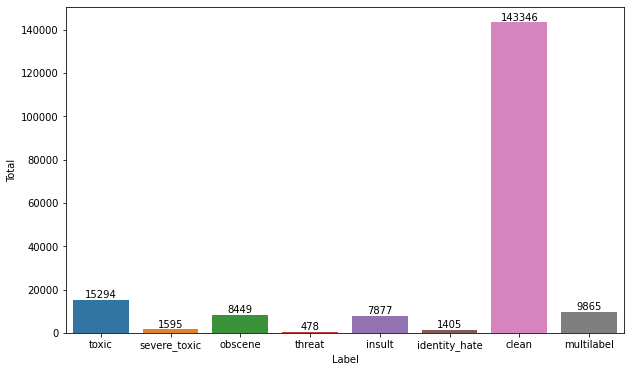

In [8]:
train_plot = train_df.drop(['id', 'comment_text', 'occurrence'], axis=1).sum(axis=0)

plt.figure(figsize=(10,6))
ax = sns.barplot(train_plot.index, train_plot.values)
plt.xlabel('Label')
plt.ylabel('Total')

rects = ax.patches
totals = train_plot.values

for rect, total in zip(rects, totals):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2, height+5, total, ha='center', va='bottom')

It can be seen that we faced imbalanced case. Almost 90% data are clean, while ~10% are dsitributed between toxic family labels. Also there are ~6% data that has more than 1 labels.

Wordcloud
===

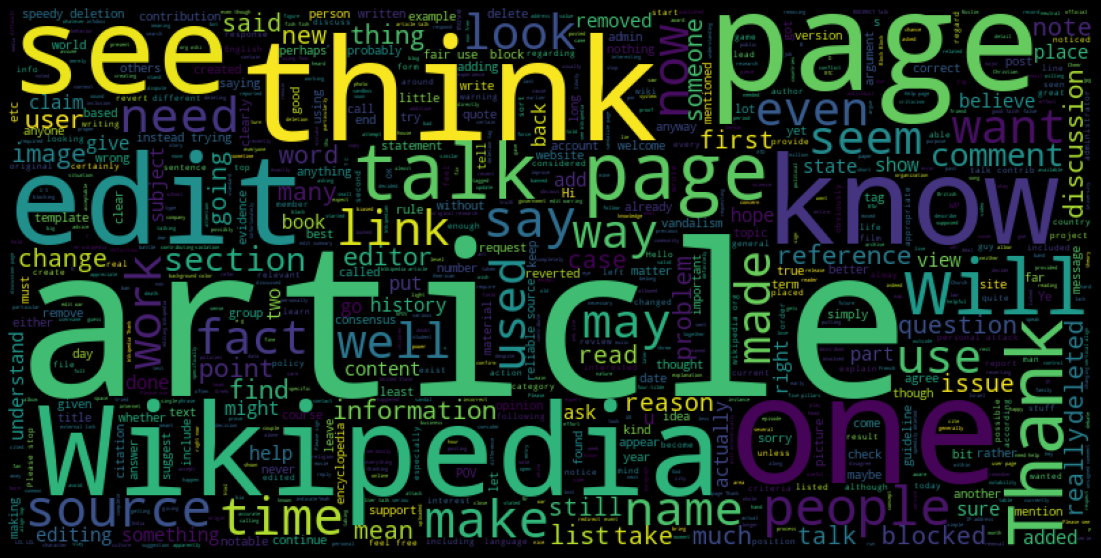

In [9]:
# stopwords
wc_stopwords = set(STOPWORDS)

# subset clean comment
clean = train_df[train_df['clean'] == 1].comment_text.values

wc = WordCloud(width=800, height=400, background_color='black', max_words=2000, stopwords=wc_stopwords)
wc_img = wc.generate(" ".join(clean))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc_img)
plt.axis('off')
plt.show()

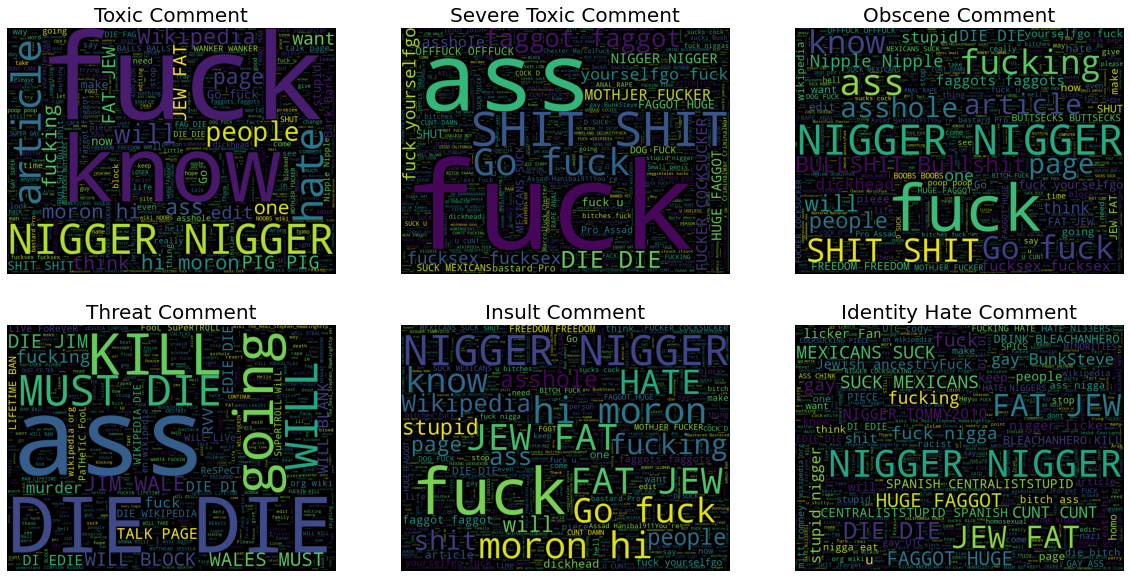

In [10]:
wc = WordCloud(width=800, height=600, background_color='black', max_words=4000, stopwords=wc_stopwords)

plt.figure(figsize=(20,10))

# wc = WordCloud(width=1200, height=800, background_color='black', max_words=2000, stopwords=wc_stopwords)

# subset toxic comment
toxic = train_df[train_df['toxic'] == 1].comment_text.values

# toxic wordcloud
wc_toxic = wc.generate(" ".join(toxic))
plt.subplot(231)
plt.axis('off')
plt.title('Toxic Comment', fontsize=20)
plt.imshow(wc_toxic)


# subset severe toxic comment
severe = train_df[train_df['severe_toxic'] == 1].comment_text.values

# severe toxic wordcloud
wc_severe = wc.generate(' '.join(severe))
plt.subplot(232)
plt.axis('off')
plt.title('Severe Toxic Comment', fontsize=20)
plt.imshow(wc_severe)


# subset obscene comment
obscene = train_df[train_df['obscene'] == 1].comment_text.values

# obscene wordcloud
wc_obscene = wc.generate(' '.join(obscene))
plt.subplot(233)
plt.axis('off')
plt.title('Obscene Comment', fontsize=20)
plt.imshow(wc_obscene)


# subset threat comment
threat = train_df[train_df['threat'] == 1].comment_text.values

# threat wordcloud
wc_threat = wc.generate(' '.join(threat))
plt.subplot(234)
plt.axis('off')
plt.title('Threat Comment', fontsize=20)
plt.imshow(wc_threat)


# subset insult comment
insult = train_df[train_df['insult'] == 1].comment_text.values

# insult wordcloud
wc_insult = wc.generate(' '.join(insult))
plt.subplot(235)
plt.axis('off')
plt.title('Insult Comment', fontsize=20)
plt.imshow(wc_insult)


# subset identity hate
identity_hate = train_df[train_df['identity_hate'] == 1].comment_text.values

# identity hate wordcloud
wc_identity_hate = wc.generate(' '.join(identity_hate))
plt.subplot(236)
plt.axis('off')
plt.title('Identity Hate Comment', fontsize=20)
plt.imshow(wc_identity_hate)

plt.show()

Feature Extraction
===

In [11]:
# keep comment text only for simplicity
df = train_df.iloc[:, :2]
df.head()

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [12]:
df['count_sent'] = df['comment_text'].apply(lambda x: len(re.findall('\n', str(x)))+1)
df['count_word'] = df['comment_text'].apply(lambda x: len(str(x).split()))
df['count_unique_word'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))
df['count_letters'] = df['comment_text'].apply(lambda x: len(str(x)))
df['count_punct'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df['count_words_upper'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df['count_words_title'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.istitle]))
df['count_stopwords'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

df.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,43,18,5.162791
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,17,2,5.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,42,20,4.571429
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,113,56,4.486726
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,13,5,4.230769


In [13]:
# derived features
df['word_unique_percent'] = df['count_unique_word'] * 100 / df['count_word']
df['punct_percent'] = df['count_punct'] * 100 / df['count_word']

df.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_length,word_unique_percent,punct_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,43,18,5.162791,95.348837,23.255814
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,17,2,5.588235,100.000000,70.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,42,20,4.571429,92.857143,14.285714
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,113,56,4.486726,72.566372,18.584071
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,13,5,4.230769,100.000000,38.461538


In [14]:
# subset of labels
train_labels = train_df.iloc[:, 2:]

# merge into single dataframe
train_features = pd.concat([df, train_labels], axis=1)

train_features.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,...,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,43,18,...,23.255814,0,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,17,2,...,70.588235,0,0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,42,20,...,14.285714,0,0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,113,56,...,18.584071,0,0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,13,5,...,38.461538,0,0,0,0,0,0,0,1,0


## Mutual Information Analysis

In [52]:
from sklearn.feature_selection import mutual_info_classif

predictor = train_features.iloc[:, 2:13]
target = train_features.iloc[:, 13]

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_series = pd.Series(mi_scores, index=X.columns)
    # mi_series = mi_series.sort_values(ascending=False)

    return mi_series

In [59]:
scores = make_mi_scores(predictor, target)
scores = scores.sort_values(ascending=False)
scores

mean_word_length       0.014056
count_punct            0.013304
punct_percent          0.012941
word_unique_percent    0.012605
count_letters          0.011201
count_unique_word      0.011055
count_words_upper      0.009715
count_stopwords        0.009685
count_word             0.009665
count_words_title      0.008589
count_sent             0.006867
dtype: float64

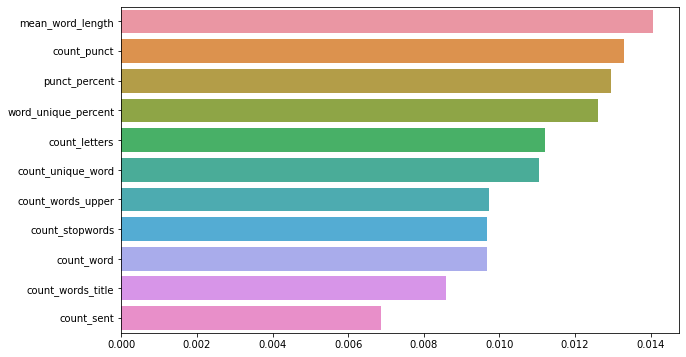

In [60]:
plt.figure(figsize=(10,6))
sns.barplot(x=scores, y=scores.index)
plt.show()

## Feature Importance with XGBoost

In [65]:
target.unique()

array([0, 1])

In [72]:
from xgboost import XGBClassifier, plot_importance

xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(predictor, target)

[08:33:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [73]:
print(xgb.feature_importances_)

[0.08823949 0.04974879 0.10784478 0.10823794 0.06479447 0.23913749
 0.         0.06485992 0.08697797 0.09737987 0.09277926]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

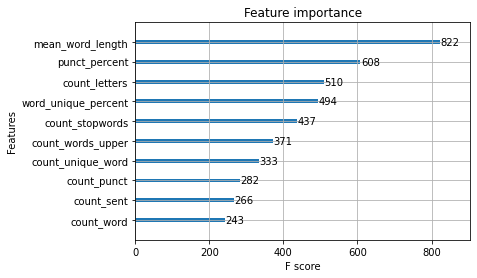

In [74]:
plot_importance(xgb)